In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/CNN-RNN

/content/drive/MyDrive/CNN-RNN


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [ ]:
df1 = pd.read_csv('Fake.csv')
df = pd.read_csv('True.csv')

Preprocessing

In [ ]:
df1['is_real'] = 0
df['is_real'] = 1
df = df.append(df1)
df.drop(['date'],axis=1,inplace=True)
df.drop(['title'],axis=1,inplace=True)
df.drop(['subject'],axis=1,inplace=True)
df.head()

,text,is_real
0,WASHINGTON (Reuters) - The head of a conservat...,1
1,WASHINGTON (Reuters) - Transgender people will...,1
2,WASHINGTON (Reuters) - The special counsel inv...,1
3,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


In [ ]:
#dropping incomplete data
df=df.dropna()
#shuffling the rows
df=df.sample(frac=1)
df.index = range(df.shape[0])
df

,text,is_real
0,MOSCOW (Reuters) - Russia is committed to hono...,1
1,(Reuters) - United Auto Workers President Denn...,1
2,MOSCOW (Reuters) - Russian President Vladimir ...,1
3,"As we know, the final United Nations General A...",0
4,(Reuters) - Missouri’s Republican governor on ...,1
...,...,...
44893,WASHINGTON (Reuters) - U.S. President Donald T...,1
44894,This is especially monumental since the Wall S...,0
44895,WASHINGTON (Reuters) - Democratic presidential...,1
44896,Florida Republicans have sponsored a bill that...,0


In [ ]:
x=df["text"]
y=df["is_real"]
# X=X[0:2500]
# y=y[0:2500]
x.shape

(44898,)

Removing stop words

In [ ]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
ps = PorterStemmer()
corpus = []
for i in range(0, len(x)):
    print(i)
    review = re.sub('[^a-zA-Z]', ' ', x[i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

Streaming output truncated to the last 5000 lines.
39898
39899
39900
39901
39902
39903
39904
39905
39906
39907
39908
39909
39910
39911
39912
39913
39914
39915
39916
39917
39918
39919
39920
39921
39922
39923
39924
39925
39926
39927
39928
39929
39930
39931
39932
39933
39934
39935
39936
39937
39938
39939
39940
39941
39942
39943
39944
39945
39946
39947
39948
39949
39950
39951
39952
39953
39954
39955
39956
39957
39958
39959
39960
39961
39962
39963
39964
39965
39966
39967
39968
39969
39970
39971
39972
39973
39974
39975
39976
39977
39978
39979
39980
39981
39982
39983
39984
39985
39986
39987
39988
39989
39990
39991
39992
39993
39994
39995
39996
39997
39998
39999
40000
40001
40002
40003
40004
40005
40006
40007
40008
40009
40010
40011
40012
40013
40014
40015
40016
40017
40018
40019
40020
40021
40022
40023
40024
40025
40026
40027
40028
40029
40030
40031
40032
40033
40034
40035
40036
40037
40038
40039
40040
40041
40042
40043
40044
40045
40046
40047
40048
40049
40050
40051
40052
40053
40054
40055
4

Tokenizing

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer                    
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words=140000)
tokenizer.fit_on_texts(corpus)
x = tokenizer.texts_to_sequences(corpus)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
maxlen = 300

x = pad_sequences(x, padding='post', maxlen=maxlen)


SPLITTING DATA SET

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
x_train, x_valid, y_train, y_valid = train_test_split(x,y,test_size=0.20, random_state=1000)
x_train, x_test, y_train, y_test = train_test_split(x_train,y_train,test_size=0.20, random_state=1000)

Glove pretrained embeddings

In [ ]:
#uncomment if not downloaded
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove*.zip

In [ ]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
  
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

embedding_dim = 100
embedding_matrix = create_embedding_matrix('glove.6B.100d.txt',
                                            tokenizer.word_index,  
                                            embedding_dim)

MODEL

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

TRAINING

In [ ]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    validation_data=(x_valid, y_valid),
                    batch_size=50)

Epoch 1/10
575/575 [==============================] - 189s 328ms/step - loss: 0.2871 - accuracy: 0.9004 - val_loss: 0.3137 - val_accuracy: 0.8845
Epoch 2/10
575/575 [==============================] - 187s 325ms/step - loss: 0.1896 - accuracy: 0.9401 - val_loss: 0.1008 - val_accuracy: 0.9715
Epoch 3/10
575/575 [==============================] - 188s 326ms/step - loss: 0.1711 - accuracy: 0.9501 - val_loss: 0.1620 - val_accuracy: 0.9454
Epoch 4/10
575/575 [==============================] - 189s 329ms/step - loss: 0.0989 - accuracy: 0.9772 - val_loss: 0.0844 - val_accuracy: 0.9805
Epoch 5/10
575/575 [==============================] - 191s 332ms/step - loss: 0.0760 - accuracy: 0.9770 - val_loss: 0.0517 - val_accuracy: 0.9831
Epoch 6/10
575/575 [==============================] - 198s 345ms/step - loss: 0.0263 - accuracy: 0.9935 - val_loss: 0.0363 - val_accuracy: 0.9909
Epoch 7/10
575/575 [==============================] - 192s 334ms/step - loss: 0.0147 - accuracy: 0.9971 - val_loss: 0.0367 -

RESULTS

In [ ]:
#load model with best results
# from tensorflow import keras
# model = keras.models.load_model('gloveCNN1.h5')

In [ ]:
from math import floor
from sklearn.metrics import classification_report, confusion_matrix
def performance(x_test, y_test):
  y_pred=model.predict(x_test)
  # print(y_pred[0])
  y_pred=[1 if x>=0.5 else 0 for x in y_pred]
  # print(y_pred[0])
  cm=confusion_matrix(y_test, y_pred)
  cr=classification_report(y_test, y_pred)

  print("Confusion matrix=\n",cm)
  print("Classification report=\n",cr)

  loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
  print("Testing Accuracy: {:.2f}%".format(accuracy*100))#actual accuracy
  print("Testing Loss: {:.2f}%".format(loss*100)) #testing loss

#call the performance measure function
performance(x_test, y_test)

Confusion matrix=
 [[3751   41]
 [  31 3361]]
Classification report=
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3792
           1       0.99      0.99      0.99      3392

    accuracy                           0.99      7184
   macro avg       0.99      0.99      0.99      7184
weighted avg       0.99      0.99      0.99      7184

Testing Accuracy: 99.00%
Testing Loss: 4.28%


Plotting graph

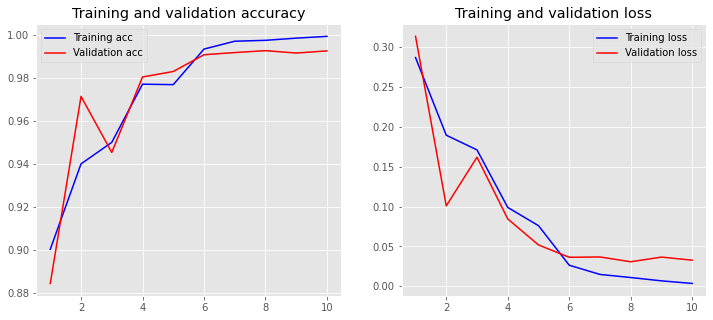

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()



plot_history(history)

In [ ]:
#save model
model.save('gloveCNN1.h5')

